In [1]:
%matplotlib inline

intro
link to binder, website, intro, topics

- string splitting
- test with plotting
- keep mechanics

`XdY`

**Roll X die each with Y sides**

In [2]:
import numpy as np
# link to numpy tutorial TODO
import matplotlib.pyplot as plt
# link TODO
import re
# description, link to regexr TODO

In [3]:
x = "5d6"
x.split('d')

['5', '6']

In [4]:
def simple_roll(dice):
    '''docstring'''
    number, sides = dice.split('d')
    number = int(number)
    sides = int(sides)
    rolls = np.random.randint(1,sides+1, size=number)
    return rolls

In [79]:
simple_roll('5d6')

array([5, 5, 4, 4, 4])

### Plotting the Results



Mean: 17.4858
Expected Mean: 17.5


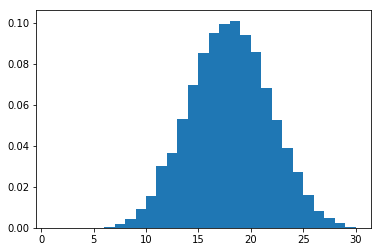

In [70]:
trials = 10000
test_rolls = [0] * trials
for i in range(trials):
    test_rolls[i] = np.sum(simple_roll('5d6'))
    
bins = np.arange(1, np.max(test_rolls)+1)
plt.hist(test_rolls, bins=bins, density=True)
print("Mean: " + str(np.mean(test_rolls)))
print('Expected Mean: ' + str(3.5*5))

## Roll and Keep

There are more complicated things that some games do, like generating ability scores for Dungeons and Dragons by rolling 4 6-sided die and keeping the highest 3 of those.

`XdYkN`

**Roll X die each with Y sides, and then only keep the highest N number of those dice.

How can we get a program to parse this sort of roll? One idea would be to extend what we have so far, splitting the string where the 'k' is located to find how many we want to keep, and then rolling the rest of the dice as before.

In [7]:
x = '4d6k3'
x.split('k')

['4d6', '3']

In [8]:
# concepting out how to only keep the 4 highest dice in a given set
rolls = simple_roll('9d6')
rolls
x = np.partition(rolls, 4)
# TODO: link to post
print(x)
x[-4:]

[1 1 2 2 3 5 5 6 6]


array([5, 5, 6, 6])

In [9]:
def keep_dice(dice):
    '''docstring'''
    base_roll, keep = dice.split('k')
    keep = int(keep)
    rolls = simple_roll(base_roll)
    #link to stack exchange for partition
    kept_rolls = np.partition(rolls, keep)[-keep:]
    return kept_rolls

In [67]:
keep_dice('4d6k3')

array([3, 6, 6])

Mean: 12.0696


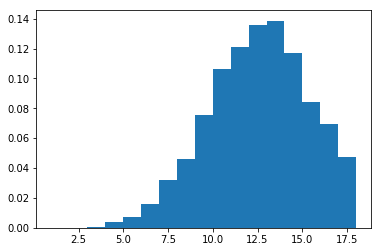

In [71]:
trials = 10000
test_rolls = [0] * trials
for i in range(trials):
    test_rolls[i] = np.sum(keep_dice('4d6k3'))
    
bins = np.arange(1, np.max(test_rolls)+1)
plt.hist(test_rolls, bins=bins, density=True)
print("Mean: " + str(np.mean(test_rolls)))

Trying this out on 4d6 we can see that it generally shifts the distribution upwards a bit, and raises the average on what would be expected for 3d6.

### Regex to the Rescue

While this has worked well so far for parsing strings in to dice rolls, there are two main problems with the simple approach of using basic string manipulation.

- there is no error checking, and even worse, passing '4d6' to the keep function will cause it to fail
- as we want to capture more complicated scenarios the functions will get very messy

What would be nice to have is a description of what valid dice notation looks like, and a function which can process anything in that notation. This is where the regular expressions come in.

Conceptually this is

(the number of dice we want to roll) (the letter d) (how many sides these dice have)

and in the language of regex we can break this down as
- `\d` a single digit
- `+` one of more of the last item
- all letters in regex match exactly that letter, and we need to find the letter `d`

so each of these becomes
- the number of dice we want to roll = `\d+`
- the letter d = `d`
- the number of sides each die has = `\d+`

regex also has a concept called capture groups, meaning that in addition to making sure that the pattern looks right, we want to use part of that pattern later for something useful. Capture groups go in parenthesis so the final expression for a simple die roll is

`(\d+)d(\d+)`

or for a roll where you only keep so many of the die

`(\d+)d(\d+)k(\d+)`

In [72]:
# lets try this out
match = re.search(r'(\d+)d(\d+)','5d6')
match.groups()

('5', '6')

In [74]:
# if the pattern isn't right a None object is returned
match = re.search(r'(\d+)d(\d+)','this is not a valid dice notation')
print(match)

None


### Exploding Dice

Lets introduce a new dice concept to stretch our new regex power, exploding dice. Say you have a game where you roll some 6-sided die, and for every 6 you roll you get to roll one additional die.

`XdY!`

**Roll X die with Y sides, and for every max valued die roll an additional Y-sided die and add it to the pile (meaning you may end up with more than X total rolls after this is all done).

But in fact we would also like to be able to say things like "4d6k3!", combining the keep mechanic and exploding dice mechanic. So in front of the ! we can have either of the two. The bar, `|`, means either of the two surrounding items, resulting in the thorny regex

`((\d+)d(\d+))|((\d+)d(\d+)k(\d+))!`

which is expressed a bit more reasonably when broken down in to sections

In [75]:
dice_expr = r'(\d+)d(\d+)'
keep_expr = dice_expr + 'k(\d+)'
explode_expr = '(' + dice_expr + '|' + keep_expr + ')!'

Alternatively regex also allows certain clauses to be marked as optional, which we could used to indicate the the `kN` portion is not strictly needed in order to be considered valid.

Lets test some of these out by writing some input and labeling it as the type of roll which needs to be done.

In [76]:
test_cases = {
    '5d6' : 'dice',
    '5dd6' : 'invalid',
    '90d1' : 'dice',
    '4d6k3' : 'keep',
    '4d6!' : 'explode',
    '9k3' : 'invalid',
    'lol' : 'invalid',
    '4d6k3!' : 'explode',
    '2d20k1' : 'keep'
}

In [77]:
dice_re = re.compile(dice_expr) # turn the expression in to a regex object
for dice, answer in test_cases.items(): # look at each case in the test_cases
    match = dice_re.fullmatch(dice) # try to see if it matches
    if match is not None and answer == 'dice':
        print('Good ' + dice)
    elif match is None and answer != 'dice':
        print('Good ' + dice)
    else:
        print('Bad  ' + dice)

Good 9k3
Good 5d6
Good 90d1
Good 5dd6
Good lol
Good 4d6k3!
Good 4d6k3
Good 4d6!
Good 2d20k1


In [78]:
regex = re.compile(keep_expr) # test the keep ones
expected_answer = 'keep'

for dice, answer in test_cases.items():
    match = regex.fullmatch(dice)
    if match is not None and answer == expected_answer:
        print('Good ' + dice)
    elif match is None and answer != expected_answer:
        print('Good ' + dice)
    else:
        print('Bad  ' + dice)
        
        
regex = re.compile(explode_expr) # test the exploding dice
expected_answer = 'explode'

for dice, answer in test_cases.items():
    match = regex.fullmatch(dice)
    if match is not None and answer == expected_answer:
        print('Good ' + dice)
    elif match is None and answer != expected_answer:
        print('Good ' + dice)
    else:
        print('Bad  ' + dice)

Good 9k3
Good 5d6
Good 90d1
Good 5dd6
Good lol
Good 4d6k3!
Good 4d6k3
Good 4d6!
Good 2d20k1
Good 9k3
Good 5d6
Good 90d1
Good 5dd6
Good lol
Good 4d6k3!
Good 4d6k3
Good 4d6!
Good 2d20k1


With this working we can make a function which accepts any of these forms and rolls the dice.

In [56]:
def roll_dice(number, sides, keep=None, explode=False):
    '''docstring'''
    
    if number == 0:
        return []
    
    rolls = np.random.randint(1,sides+1,number)
    
    if explode: #roll additional dice for highest values
        num_max = np.sum(rolls == sides)
        rolls = np.append(rolls, 
                         roll_dice(num_max, sides, keep=None, explode=explode))
        
    if keep is not None:
        rolls = np.partition(rolls, keep)[-keep:]
        
    return rolls

def regex_roll(dice, keep=None, explode=False):
    '''docstring'''
    dice_expr = r'(\d+)d(\d+)'
    keep_expr = '(' + dice_expr + ')' + 'k(\d+)'
    explode_expr = '(' + dice_expr + '|' + keep_expr + ')!'
    
    explode_re = re.compile(explode_expr)
    match = explode_re.fullmatch(dice)
    
    if match is not None: # exploding dice roll
        return regex_roll(match.group(1), explode=True)
    
    keep_re = re.compile(keep_expr)
    match = keep_re.fullmatch(dice)
    
    if match is not None: #keep dice
        keep = int(match.groups()[3])
        dice = match.groups()[0]
        return regex_roll(dice, keep=keep, explode=explode)
    
    dice_re = re.compile(dice_expr)
    match = dice_re.fullmatch(dice)
    
    if match is None:
        raise ValueError('Invalid dice notation: ' + dice)
    
    number, sides = map(int, match.groups())
    
    return roll_dice(number, sides, keep, explode)

In [64]:
regex_roll('4d6!')

array([5., 1., 5., 6., 2.])

## Getting Crazy

So we have a function which covers most of the commonly used dice systems for games. But there is much more

- what if we want to roll different kinds of dice?
- treat all rolls below a 3 as being equal to a 3
- count how many rolls are greater than 8

but why limit ourselves to the realm of sane dice mechanics, why not...

`(1d4+2d6)d20!>10`

Roll a d4 and two 6-sided die, add them up, then roll that number of exploding 20-sided die and count how many of those rolled higher than a 10. 

You may ask why, and the reasons are
- to drive players insane
- to teach you about compiler designer and parse trees

At this point something surprising happens, despite seemingly limitless potential no regular expression can possibly describe all of the valid rolls in this notation. What really trips it up is being able to nest sub-rolls inside of parenthesis. 